In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, make_scorer

In [5]:
# Load data
df = pd.read_csv("/Users/mariahloehr/IICD/IICD/Data/cell_cycle_tidied.csv")

# Separate features and target
X = df.drop(columns=['phase', 'age', 'PHATE_1', 'PHATE_2'])
y = df['age']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=949)

In [6]:
# Define MLP regressor
mlp = MLPRegressor(max_iter=1000, random_state=949)

In [ ]:
# Hyperparameter tuning
param_grid = {
    'hidden_layer_sizes': [
        (300, 150),     # 2 hidden layers
        (150, 75),     # 2 hidden layers
        (300, 150, 75), # 3 hidden layers
        (300,300,300)   # 3 hidden layers
    ]
}

# GridSearchCV using RMSE as scoring

grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=10,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train)

# Output best parameters and score (convert to positive RMSE)
print("Best parameters:", grid_search.best_params_)


Best parameters: {'hidden_layer_sizes': (300, 150, 75)}


In [12]:
# Convert the cv_results_ dictionary to a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Select and display relevant columns
print(
    results_df[
        [
            'param_hidden_layer_sizes',
            'mean_test_score',
            'std_test_score',
            'rank_test_score'
        ]
    ].sort_values(by='rank_test_score')
)

  param_hidden_layer_sizes  mean_test_score  std_test_score  rank_test_score
6           (300, 150, 75)        -1.728659        0.087519                1
4               (300, 150)        -1.778945        0.113003                2
7          (300, 300, 300)        -1.783591        0.181624                3
2                   (500,)        -1.878508        0.199779                4
1                   (300,)        -1.889136        0.198220                5
3                    (50,)        -1.903292        0.143020                6
5                (150, 75)        -1.906592        0.236229                7
0                   (150,)        -1.971648        0.262487                8


In [13]:
# Retrain with best estimator
best_mlp = grid_search.best_estimator_
best_mlp.fit(X_train, y_train)

# Predictions
y_train_pred = best_mlp.predict(X_train)
y_test_pred = best_mlp.predict(X_test)

In [14]:
# Evaluation
# Calculate RMSE
rmse_train = root_mean_squared_error(y_train, y_train_pred)
rmse_test = root_mean_squared_error(y_test, y_test_pred)

print("=== Training Set ===")
print(f"RMSE: {rmse_train:.4f}")

print("\n=== Test Set ===")
print(f"RMSE: {rmse_test:.4f}")

# For training set
df_train = pd.DataFrame({
    'true_age': y_train,
    'pred_age': y_train_pred,
    'phase': df.loc[y_train.index, 'phase']  # get phase for train samples
})

rmse_per_phase_train = df_train.groupby('phase').apply(
    lambda x: np.sqrt(mean_squared_error(x['true_age'], x['pred_age']))
)

print("RMSE per phase (Train):")
print(rmse_per_phase_train)

# For test set
df_test = pd.DataFrame({
    'true_age': y_test,
    'pred_age': y_test_pred,
    'phase': df.loc[y_test.index, 'phase']  # get phase for test samples
})

rmse_per_phase_test = df_test.groupby('phase').apply(
    lambda x: np.sqrt(mean_squared_error(x['true_age'], x['pred_age']))
)

print("\nRMSE per phase (Test):")
print(rmse_per_phase_test)

=== Training Set ===
RMSE: 0.3897

=== Test Set ===
RMSE: 1.7178
RMSE per phase (Train):
phase
G0    0.408262
G1    0.280366
G2    0.556209
M     1.159919
S     0.374165
dtype: float64

RMSE per phase (Test):
phase
G0    1.699445
G1    1.380948
G2    2.078957
M     9.560191
S     1.448986
dtype: float64


/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_21021/1916931970.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_phase_train = df_train.groupby('phase').apply(
/var/folders/1s/bvxr71hj0hqgyk_jk6k7wkm80000gn/T/ipykernel_21021/1916931970.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_phase_test = df_test.groupby('phase').apply(


In [16]:
# === Load existing results DataFrame ===
results_df = pd.read_csv("/Users/mariahloehr/IICD/IICD/Bar Plot/regression_results.csv", index_col=0)

# === Set values ===
model_name = "MLP (full)"  # or whatever is appropriate
results_df.loc[model_name, 'Overall'] = rmse_test

# Fill in per-phase RMSEs
for phase in ['G0', 'G1', 'G2', 'M', 'S']:
    if phase in rmse_per_phase_test.index:
        results_df.loc[model_name, phase] = rmse_per_phase_test[phase]

# === Save updated results ===
results_df.to_csv("/Users/mariahloehr/IICD/IICD/Bar Plot/regression_results.csv")

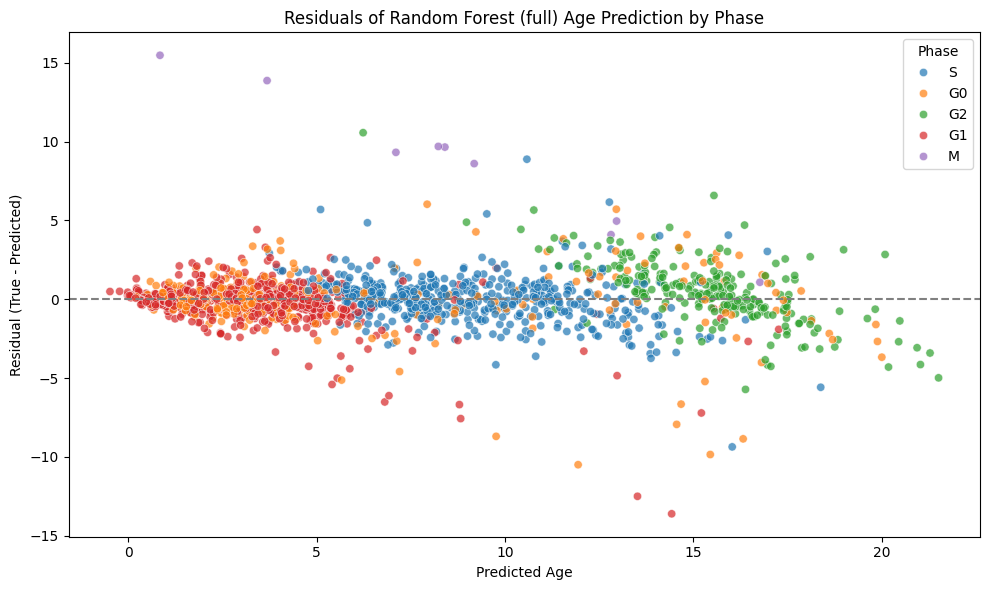

In [15]:
## PLOT RESIDUALS
# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'True Age': y_test,
    'Predicted Age': y_test_pred,
    'Residual': y_test - y_test_pred,
    'Phase': df.loc[y_test.index, 'phase']
})

# Plot residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_plot,
    x='Predicted Age',
    y='Residual',
    hue='Phase',
    palette='tab10',
    alpha=0.7
)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residuals of Random Forest (full) Age Prediction by Phase")
plt.xlabel("Predicted Age")
plt.ylabel("Residual (True - Predicted)")
plt.legend(title='Phase')
plt.tight_layout()

# Save the plot
plot_path = "mlp_regression_full.png"
plt.savefig(plot_path, dpi=300)
plt.show()